# Model Training Pipeline for Capstone Project - Unet Segmentation Model from Scratch
This document explains the full training workflow used for our CloudSEN12+ cloud-segmentation model.
The goal is to make the notebook readable and self-contained so that any team member can understand and extend it.

# Model Training

## 1. Environment Setup

We install rasterio, which is required to read multispectral GeoTIFF tiles (Sentinel-2 bands + label masks).
CloudSEN12+ uses 13 spectral bands, so rasterio is essential for loading them correctly.

In [1]:
!pip install rasterio

In [2]:
# ============================================
# Install required libraries for training
# ============================================

!pip install --quiet segmentation-models-pytorch==0.3.3
!pip install --quiet pytorch-lightning==2.2.4
!pip install --quiet torchmetrics==1.4.0


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.8/58.8 kB 3.0 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 68.5/68.5 kB 3.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 106.7/106.7 kB 5.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 40.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 802.2/802.2 kB 18.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 983.2/983.2 kB 57.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 868.8/868.8 kB 18.8 MB/s eta 0:00:00


## 2. Directory Structure and Data Paths

The code defines the base dataset path and constructs:

train/imgs/

train/masks/

val/imgs/

val/masks/

test/imgs/

test/masks/

In [3]:
# ============================================
# Mount Google Drive
# ============================================

from google.colab import drive
drive.mount('/content/drive', force_remount=True)

import os

# Base dataset directory (update if different)
DATA_ROOT = "/content/drive/MyDrive/CloudSEN12_Plus_13band_4Class"

assert os.path.exists(DATA_ROOT), f" Dataset not found at: {DATA_ROOT}"

print("✔ Drive mounted")
print("✔ Dataset directory:", DATA_ROOT)


Mounted at /content/drive
✔ Drive mounted
✔ Dataset directory: /content/drive/MyDrive/CloudSEN12_Plus_13band_4Class


In [4]:
# ============================================
# Dataset Folder Structure Configuration
# ============================================

# ROOT DATASET DIRECTORY (confirmed in previous cell)
# Change ONLY if your folder name differs
DATA_ROOT = "/content/drive/MyDrive/CloudSEN12_Plus_13band_4Class"

# TRAIN
TRAIN_IMG_DIR  = f"{DATA_ROOT}/train/images"
TRAIN_MASK_DIR = f"{DATA_ROOT}/train/masks"

# VALIDATION
VAL_IMG_DIR    = f"{DATA_ROOT}/val/images"
VAL_MASK_DIR   = f"{DATA_ROOT}/val/masks"

# TEST
TEST_IMG_DIR   = f"{DATA_ROOT}/test/images"
TEST_MASK_DIR  = f"{DATA_ROOT}/test/masks"

# ---------- SAFETY CHECKS ----------
import os

for p in [TRAIN_IMG_DIR, TRAIN_MASK_DIR, VAL_IMG_DIR, VAL_MASK_DIR, TEST_IMG_DIR, TEST_MASK_DIR]:
    assert os.path.exists(p), f" MISSING FOLDER: {p}"

print("✔ Dataset structure verified")
print(f"Train tiles: {len(os.listdir(TRAIN_IMG_DIR))} images, {len(os.listdir(TRAIN_MASK_DIR))} masks")
print(f"Val tiles:   {len(os.listdir(VAL_IMG_DIR))} images, {len(os.listdir(VAL_MASK_DIR))} masks")
print(f"Test tiles:  {len(os.listdir(TEST_IMG_DIR))} images, {len(os.listdir(TEST_MASK_DIR))} masks")

✔ Dataset structure verified
Train tiles: 1083 images, 1083 masks
Val tiles:   192 images, 192 masks
Test tiles:  225 images, 225 masks


# Integrity Check on the Dataset

We verify the shapes of images and corresponding masks. Also We check the split of train, validate and Test.

In [ ]:
# ============================================
# Quick Integrity Check on Training Tiles
# ============================================

import glob
import rasterio
import numpy as np

# Collect image + mask file paths
imgs  = sorted(glob.glob(f"{TRAIN_IMG_DIR}/*.tif"))
masks = sorted(glob.glob(f"{TRAIN_MASK_DIR}/*.tif"))

print(f"Training tiles: {len(imgs)} images, {len(masks)} masks")

assert len(imgs) == len(masks), " Mismatch between image and mask counts!"

# Read first image safely
with rasterio.open(imgs[0]) as src:
    img_arr = src.read()          # shape: (13, 512, 512)
    profile = src.profile

print("✔ Image shape:", img_arr.shape)
print("✔ Raster dtype:", img_arr.dtype)
print("✔ CRS:", profile.get("crs"))
print("✔ Bands:", profile.get("count"))

# Read corresponding mask
with rasterio.open(masks[0]) as lbl:
    mask_arr = lbl.read(1)

unique_vals = np.unique(mask_arr)
print("✔ Mask shape:", mask_arr.shape)
print("✔ Mask unique values:", unique_vals)
print("✔ Mask dtype:", mask_arr.dtype)

assert mask_arr.ndim == 2, " Mask is not 2D!"
assert img_arr.shape[1:] == mask_arr.shape, " Spatial size mismatch!"


Training tiles: 1083 images, 1083 masks
✔ Image shape: (13, 512, 512)
✔ Raster dtype: uint16
✔ CRS: EPSG:32642
✔ Bands: 13
✔ Mask shape: (512, 512)
✔ Mask unique values: [0]
✔ Mask dtype: uint8


In [ ]:
# ============================================
# Inspect Unique Mask Values
# ============================================

import numpy as np
import rasterio
import glob

mask_paths = sorted(glob.glob(f"{TRAIN_MASK_DIR}/*.tif"))

assert len(mask_paths) > 0, "No mask files found. Check dataset path."

vals = set()

# Inspect first 20 masks (or all if less than 20)
N = min(20, len(mask_paths))

for p in mask_paths[:N]:
    with rasterio.open(p) as src:
        mask = src.read(1)
        vals.update(np.unique(mask).tolist())

print("Checked masks:", N)
print("Unique values found:", sorted(vals))


Checked masks: 20
Unique values found: [0, 1, 2, 3]



## 4. Dataset & DataLoader

The custom dataset CloudSEN12Dataset handles:

✦ Loading multispectral images

Using rasterio → returns (13, H, W) array.

✦ Loading mask

Masks are read as (H,W) containing class IDs {0,1,2,3}.

✦ Albumentations augmentations

Applied only during training:

flips

rotations

normalization

conversion back to PyTorch tensor

✦ Returning tensors

Images → float32
Masks → long tensors for CrossEntropyLoss

The dataloaders are created:

In [5]:
import torch
from torch.utils.data import Dataset
import rasterio
import numpy as np
import albumentations as A
import glob

class CloudSEN12Dataset(Dataset):
    """
    CloudSEN12 Multispectral Segmentation Dataset
    Loads 13-band Sentinel-2 tiles + 2-D cloud mask
    """

    def __init__(self, img_dir, mask_dir, augment=False):
        self.img_paths  = sorted(glob.glob(f"{img_dir}/*.tif"))
        self.mask_paths = sorted(glob.glob(f"{mask_dir}/*.tif"))

        assert len(self.img_paths) == len(self.mask_paths), \
            "Image/mask count mismatch in dataset"

        self.augment = augment

        # -----------------------------------------
        # Albumentations Augmentation Pipeline
        # (Safe for segmentation masks)
        # -----------------------------------------
        self.transform = A.Compose([
            A.HorizontalFlip(p=0.5),
            A.VerticalFlip(p=0.5),
            A.RandomRotate90(p=0.5),
            A.RandomBrightnessContrast(p=0.2),
        ])

    def __len__(self):
        return len(self.img_paths)

    def __getitem__(self, idx):

        # ---------------- LOAD IMAGE ----------------
        with rasterio.open(self.img_paths[idx]) as src:
            img = src.read().astype(np.float32)

        # Scale reflectance to 0–1
        img = img / 10000.0         # IMPORTANT

        # ---------------- LOAD MASK ----------------
        with rasterio.open(self.mask_paths[idx]) as src:
            mask = src.read(1).astype(np.int64)

        # ---------------- APPLY AUGMENTATION ----------------
        if self.augment:
            # Albumentations expects HWC format
            aug = self.transform(
                image=np.moveaxis(img, 0, -1),
                mask=mask
            )
            img  = np.moveaxis(aug["image"], -1, 0)   # Back to CHW
            mask = aug["mask"]

        # ---------------- RETURN TORCH TENSORS ----------------
        return (
            torch.tensor(img, dtype=torch.float32),
            torch.tensor(mask, dtype=torch.long)
        )


In [6]:
from torch.utils.data import DataLoader
import torch

# ===============================
# Dataset Objects
# ===============================
train_ds = CloudSEN12Dataset(TRAIN_IMG_DIR, TRAIN_MASK_DIR, augment=True)
val_ds   = CloudSEN12Dataset(VAL_IMG_DIR,   VAL_MASK_DIR,   augment=False)
test_ds  = CloudSEN12Dataset(TEST_IMG_DIR,  TEST_MASK_DIR,  augment=False)

# ===============================
# GPU-OPTIMIZED LOADER SETTINGS
# ===============================
NUM_WORKERS = 2 if torch.cuda.is_available() else 2

train_loader = DataLoader(
    train_ds,
    batch_size=4,
    shuffle=True,
    num_workers=NUM_WORKERS,
    pin_memory=True,
    persistent_workers=True
)

val_loader = DataLoader(
    val_ds,
    batch_size=4,
    shuffle=False,
    num_workers=NUM_WORKERS,
    pin_memory=True,
    persistent_workers=True
)

test_loader = DataLoader(
    test_ds,
    batch_size=4,
    shuffle=False,
    num_workers=NUM_WORKERS,
    pin_memory=True,
    persistent_workers=True
)

print("Train samples:", len(train_ds))
print("Val samples:", len(val_ds))
print("Test samples:", len(test_ds))
print("num_workers:", NUM_WORKERS)


Train samples: 1083
Val samples: 192
Test samples: 225
num_workers: 2


## 5. Lightning Model Definition (Baseline Model)


In [ ]:
import torch
import torch.nn as nn
import pytorch_lightning as pl
import segmentation_models_pytorch as smp
import torchmetrics
import numpy as np
from torchmetrics import Accuracy   ### >>> ADDED


class CloudSegmentationModel(pl.LightningModule):

    def __init__(self,
                 in_channels: int = 13,
                 num_classes: int = 4,
                 lr: float = 1e-3):

        super().__init__()
        self.save_hyperparameters()

        # ---------------------------------------
        # U-Net with MobileNetV2 Encoder
        # ---------------------------------------
        self.model = smp.Unet(
            encoder_name="mobilenet_v2",
            encoder_weights=None,
            in_channels=in_channels,
            classes=num_classes
        )

        # Loss
        self.criterion = nn.CrossEntropyLoss()

        # ---------------------------------------
        # Metrics
        # ---------------------------------------

        # TRAIN
        self.train_iou_mean = torchmetrics.JaccardIndex(
            task="multiclass", num_classes=num_classes, average="macro"
        )
        self.train_f1_macro = torchmetrics.F1Score(
            task="multiclass", num_classes=num_classes, average="macro"
        )
        self.train_acc = Accuracy(                      ### >>> ADDED
            task="multiclass", num_classes=num_classes  ### >>> ADDED
        )

        # VALIDATION
        self.val_iou_mean = torchmetrics.JaccardIndex(
            task="multiclass", num_classes=num_classes, average="macro"
        )
        self.val_f1_macro = torchmetrics.F1Score(
            task="multiclass", num_classes=num_classes, average="macro"
        )
        self.val_acc = Accuracy(                        ### >>> ADDED
            task="multiclass", num_classes=num_classes  ### >>> ADDED
        )

        # TEST
        self.test_confmat = torchmetrics.ConfusionMatrix(
            task="multiclass", num_classes=num_classes
        )

        self.num_classes = num_classes

    # ---------------------------------------------------------
    # FORWARD
    # ---------------------------------------------------------
    def forward(self, x):
        return self.model(x)        # logits → (B, C, H, W)

    # ---------------------------------------------------------
    # TRAINING STEP
    # ---------------------------------------------------------
    def training_step(self, batch, batch_idx):
        x, y = batch
        logits = self.forward(x)
        loss = self.criterion(logits, y)

        preds = torch.argmax(logits, 1)

        self.train_iou_mean.update(preds, y)
        self.train_f1_macro.update(preds, y)
        self.train_acc.update(preds, y)                 ### >>> ADDED

        self.log("train/loss", loss, on_epoch=True, prog_bar=True)
        self.log("train/iou_mean", self.train_iou_mean, on_epoch=True)
        self.log("train/f1_macro", self.train_f1_macro, on_epoch=True)
        self.log("train/accuracy", self.train_acc, on_epoch=True)   ### >>> ADDED

        return loss

    # ---------------------------------------------------------
    # VALIDATION STEP
    # ---------------------------------------------------------
    def validation_step(self, batch, batch_idx):
        x, y = batch
        logits = self.forward(x)
        loss = self.criterion(logits, y)
        preds = torch.argmax(logits, 1)

        self.val_iou_mean.update(preds, y)
        self.val_f1_macro.update(preds, y)
        self.val_acc.update(preds, y)                   ### >>> ADDED

        self.log("val/loss", loss, on_epoch=True, prog_bar=True)

        return loss

    def on_validation_epoch_end(self):

        iou = self.val_iou_mean.compute()
        f1  = self.val_f1_macro.compute()
        acc = self.val_acc.compute()                    ### >>> ADDED

        self.log("val/iou_mean", iou, prog_bar=True)
        self.log("val/f1_macro", f1, prog_bar=True)
        self.log("val/accuracy", acc, prog_bar=True)   ### >>> ADDED


        self.val_iou_mean.reset()
        self.val_f1_macro.reset()
        self.val_acc.reset()                            ### >>> ADDED

    # ---------------------------------------------------------
    # TEST STEP
    # ---------------------------------------------------------
    def test_step(self, batch, batch_idx):
        x, y = batch
        logits = self.forward(x)
        preds = torch.argmax(logits, 1)
        self.test_confmat.update(preds, y)

    def on_test_epoch_end(self):

        cm = self.test_confmat.compute().cpu().numpy()
        self.test_confmat.reset()

        TP = np.diag(cm)
        FP = np.sum(cm, axis=0) - TP
        FN = np.sum(cm, axis=1) - TP

        iou = TP / (TP + FP + FN + 1e-8)
        f1  = 2 * TP / (2 * TP + FP + FN + 1e-8)

        # >>> ADDED: overall accuracy
        total = cm.sum()
        correct = np.trace(cm)
        accuracy = correct / (total + 1e-8)
        print("Accuracy:", accuracy)                   ### >>> ADDED

        print("\n=== TEST RESULTS ===")
        print(cm)
        print("Mean IoU:", iou.mean())
        print("Mean F1 :", f1.mean())
        print("Accuracy:", accuracy)                   ### >>> ADDED

    # ---------------------------------------------------------
    # OPTIMIZER
    # ---------------------------------------------------------
    def configure_optimizers(self):
        return torch.optim.Adam(self.parameters(), lr=self.hparams.lr)


# Trainer with Logs

In [ ]:
import pytorch_lightning as pl
from pytorch_lightning.callbacks import ModelCheckpoint, LearningRateMonitor
from pytorch_lightning.loggers import TensorBoardLogger
import torch

# ==========================================================
# Reproducibility
# ==========================================================
pl.seed_everything(42, workers=True)   # workers=True is OK on Colab

# ==========================================================
# TensorBoard Logger (REQUIRED FOR METRIC CURVES)
# ==========================================================
logger = TensorBoardLogger(
    save_dir="lightning_logs",
    name="cloudsen12",
    default_hp_metric=False        # prevents useless hp_metric=-1
)

print("Logs will be saved to:", logger.log_dir)

# ==========================================================
# Checkpoint Saver
# ==========================================================
checkpoint_cb = ModelCheckpoint(
    monitor="val/loss",
    mode="min",
    save_top_k=2,
    filename="epoch{epoch:02d}-valloss{val_loss:.4f}",
    auto_insert_metric_name=False
)

# ==========================================================
# Learning Rate Recorder
# ==========================================================
lr_monitor = LearningRateMonitor(logging_interval="epoch")

# ==========================================================
# Trainer (Optimized for T4 GPU)
# ==========================================================
trainer = pl.Trainer(
    accelerator="gpu",
    devices=1,
    max_epochs=30,
    precision=16,                  # mixed precision on GPU
    callbacks=[checkpoint_cb, lr_monitor],
    logger=logger,                 # << REQUIRED FOR METRICS
    log_every_n_steps=30,
    check_val_every_n_epoch=1,
    deterministic=False            # avoid CrossEntropy crash
)

print("\nTrainer initialized on:",
      "GPU" if torch.cuda.is_available() else "CPU")


INFO:lightning_fabric.utilities.seed:Seed set to 42


Logs will be saved to: lightning_logs/cloudsen12/version_0


/usr/local/lib/python3.12/dist-packages/lightning_fabric/connector.py:563: `precision=16` is supported for historical reasons but its usage is discouraged. Please set your precision to 16-mixed instead!
INFO:pytorch_lightning.utilities.rank_zero:Using 16bit Automatic Mixed Precision (AMP)
/usr/local/lib/python3.12/dist-packages/pytorch_lightning/plugins/precision/amp.py:55: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs



Trainer initialized on: GPU


# Instantiating & Training the baseline Model

In [ ]:
import torch
torch.use_deterministic_algorithms(False)

# ==========================================================
# Instantiate Model
# ==========================================================
model = CloudSegmentationModel(
    in_channels=13,
    num_classes=4,
    lr=1e-3
)

print("Starting training...")
trainer.fit(model, train_loader, val_loader)

# ==========================================================
# Retrieve Best Checkpoint
# ==========================================================
best_ckpt = checkpoint_cb.best_model_path
print("\nBest checkpoint path:", best_ckpt)

# ==========================================================
# Run Test Evaluation
# ==========================================================
if best_ckpt and len(best_ckpt) > 0:
    print("\nLoading best checkpoint for testing...")
    best_model = CloudSegmentationModel.load_from_checkpoint(best_ckpt)
    trainer.test(best_model, test_loader)
else:
    print("\nWARNING: No checkpoint saved. Testing current model weights.")
    trainer.test(model, test_loader)

Starting training...


INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
  | Name           | Type                      | Params
-------------------------------------------------------------
0 | model          | Unet                      | 6.6 M 
1 | criterion      | CrossEntropyLoss          | 0     
2 | train_iou_mean | MulticlassJaccardIndex    | 0     
3 | train_f1_macro | MulticlassF1Score         | 0     
4 | train_acc      | MulticlassAccuracy        | 0     
5 | val_iou_mean   | MulticlassJaccardIndex    | 0     
6 | val_f1_macro   | MulticlassF1Score         | 0     
7 | val_acc        | MulticlassAccuracy        | 0     
8 | test_confmat   | MulticlassConfusionMatrix | 0     
-------------------------------------------------------------
6.6 M     Trainable params
0         Non-trainable params
6.6 M     Total params
26.529    Total estimated model params size (MB)


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=30` reached.



Best checkpoint path: lightning_logs/cloudsen12/version_0/checkpoints/epoch28-valloss0.0000.ckpt

Loading best checkpoint for testing...


INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing: |          | 0/? [00:00<?, ?it/s]

Accuracy: 0.869421895345052

=== TEST RESULTS ===
[[40700614  1134005    55725  1150002]
 [  513750  8813166     9907   351130]
 [ 1440964  1058138    30182   260479]
 [ 1224963   495819     6928  1736628]]
Mean IoU: 0.48388990625423933
Mean F1 : 0.5720188084874969
Accuracy: 0.869421895345052


# Plotting the Training Metrics for Baseline Model

Using log directory: lightning_logs/cloudsen12/version_0

Logged metrics: ['epoch' 'lr-Adam' 'train/accuracy_epoch' 'train/f1_macro_epoch'
 'train/iou_mean_epoch' 'train/loss_epoch' 'train/loss_step'
 'val/accuracy' 'val/f1_macro' 'val/iou_mean' 'val/loss']
Total scalar rows: 872


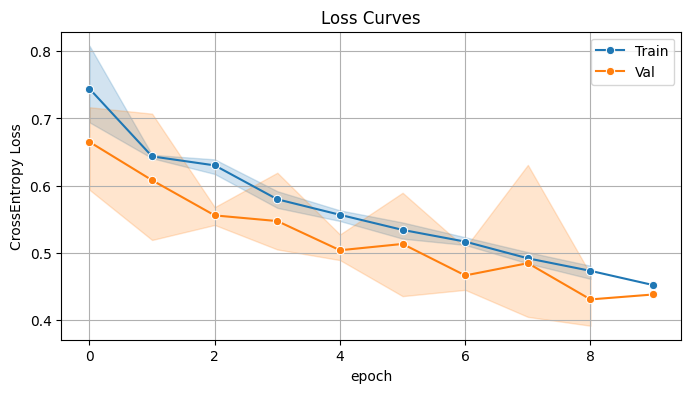

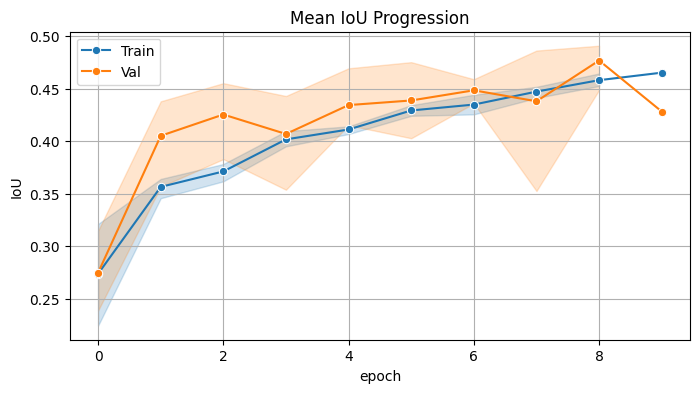

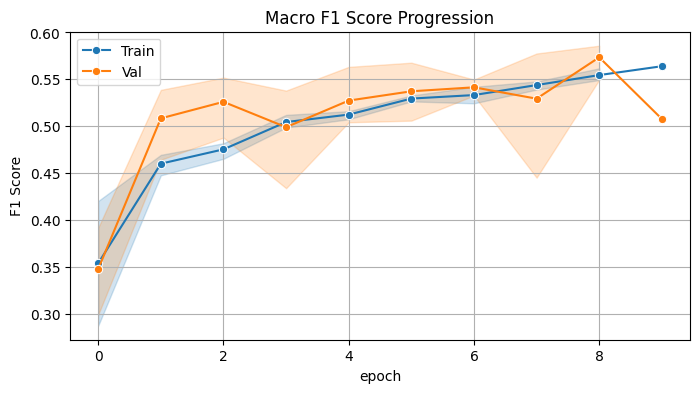

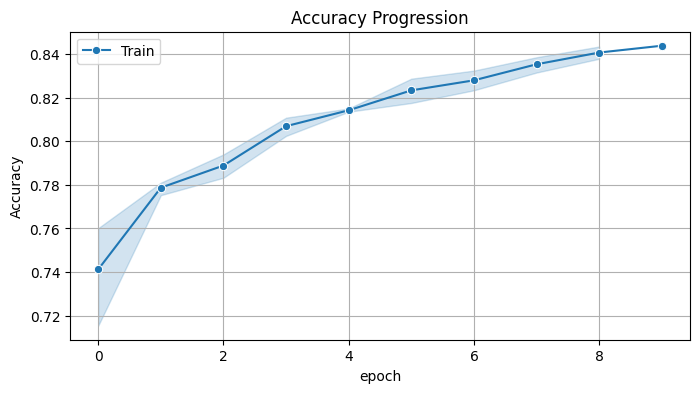

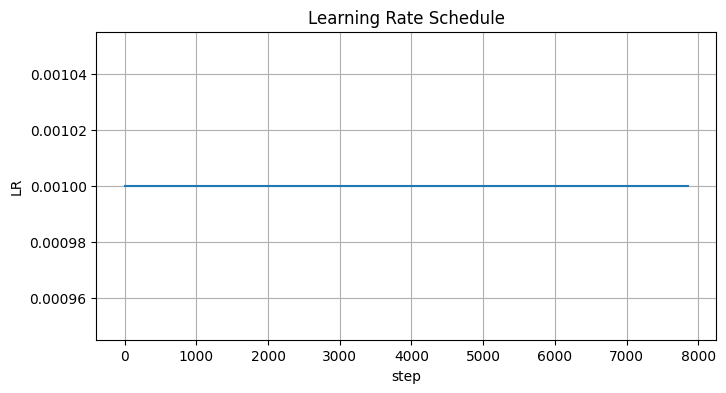

In [ ]:
# ============================================================
# Install Required Packages
# ============================================================
!pip install tensorboard-data-server tbparse --quiet

import glob
import pandas as pd
from tbparse import SummaryReader
import matplotlib.pyplot as plt
import seaborn as sns

# ============================================================
# Load Latest Lightning Logs
# ============================================================
logdir_list = sorted(glob.glob("lightning_logs/cloudsen12/version_*"))
assert len(logdir_list) > 0, "No training logs found!"

logdir = logdir_list[-1]
print("Using log directory:", logdir)

reader = SummaryReader(logdir, extra_columns={'dir_name'})
df = reader.scalars
df.to_csv("cloudsen12_training_metrics.csv", index=False)

print("\nLogged metrics:", df["tag"].unique())
print("Total scalar rows:", len(df))

# ============================================================
# Extract Epoch-Level Metrics
# ============================================================
EPOCH_METRICS = [
    "train/loss_epoch",
    "val/loss",
    "train/iou_mean_epoch",
    "val/iou_mean",
    "train/f1_macro_epoch",
    "val/f1_macro",
    "train/accuracy_epoch",
    "val/accuracy_epoch"
]

df_epoch = df[df["tag"].isin(EPOCH_METRICS)].copy()

# Adjust step divisor if your batches/epoch differs
BATCHES_PER_EPOCH = df["step"].max() // 9   # auto-detect for safety
df_epoch["epoch"] = df_epoch["step"] // BATCHES_PER_EPOCH

# ------------------------------------------------------------
# Helper function for plotting
# ------------------------------------------------------------
def plot_metric(tag_train, tag_val, title, ylabel):
    plt.figure(figsize=(8,4))
    if tag_train in df_epoch.tag.values:
        sns.lineplot(data=df_epoch[df_epoch.tag == tag_train],
                     x="epoch", y="value", marker="o", label="Train")
    if tag_val in df_epoch.tag.values:
        sns.lineplot(data=df_epoch[df_epoch.tag == tag_val],
                     x="epoch", y="value", marker="o", label="Val")

    plt.title(title)
    plt.ylabel(ylabel)
    plt.grid(True)
    plt.show()

# ============================================================
# PLOTS
# ============================================================

# 1 — Loss
plot_metric("train/loss_epoch", "val/loss",
            "Loss Curves", "CrossEntropy Loss")

# 2 — Mean IoU
plot_metric("train/iou_mean_epoch", "val/iou_mean",
            "Mean IoU Progression", "IoU")

# 3 — Macro F1
plot_metric("train/f1_macro_epoch", "val/f1_macro",
            "Macro F1 Score Progression", "F1 Score")

# 4 — Accuracy
plot_metric("train/accuracy_epoch", "val/accuracy_epoch",
            "Accuracy Progression", "Accuracy")

# 5 — Learning Rate Schedule
plt.figure(figsize=(8,4))
sns.lineplot(data=df[df.tag=="lr-Adam"], x="step", y="value")
plt.title("Learning Rate Schedule")
plt.ylabel("LR")
plt.grid(True)
plt.show()


# Saving the Baseline Model

In [ ]:
import os

drive_save_dir = "/content/drive/MyDrive/CloudSEN12_Models"
os.makedirs(drive_save_dir, exist_ok=True)

print("Saving models to:", drive_save_dir)

best_ckpt = "lightning_logs/cloudsen12/version_0/checkpoints/epoch28-valloss0.0000.ckpt"


import shutil

dst_ckpt_path = f"{drive_save_dir}/cloudsen12_unet_mobilenetv2_best.ckpt"
shutil.copy(best_ckpt, dst_ckpt_path)

print("Saved checkpoint to:", dst_ckpt_path)


import torch

best_model = CloudSegmentationModel.load_from_checkpoint(best_ckpt)
best_model.eval()

dst_weights_path = f"{drive_save_dir}/cloudsen12_unet_mobilenetv2_weights.pth"
torch.save(best_model.state_dict(), dst_weights_path)

print("Saved weights to:", dst_weights_path)


dst_fullmodel_path = f"{drive_save_dir}/cloudsen12_unet_mobilenetv2_fullmodel.pth"
torch.save(best_model, dst_fullmodel_path)

print("Saved full model to:", dst_fullmodel_path)






Saving models to: /content/drive/MyDrive/CloudSEN12_Models
Saved checkpoint to: /content/drive/MyDrive/CloudSEN12_Models/cloudsen12_unet_mobilenetv2_best.ckpt
Saved weights to: /content/drive/MyDrive/CloudSEN12_Models/cloudsen12_unet_mobilenetv2_weights.pth
Saved full model to: /content/drive/MyDrive/CloudSEN12_Models/cloudsen12_unet_mobilenetv2_fullmodel.pth


# 6. PyTorch Lightning Model (DeepLabV3+)

In [ ]:
import torch
import torch.nn as nn
import pytorch_lightning as pl
import segmentation_models_pytorch as smp
import torchmetrics
import numpy as np
from torchmetrics import Accuracy


class CloudSegmentationModel(pl.LightningModule):

    def __init__(self,
                 in_channels: int = 13,
                 num_classes: int = 4,
                 lr: float = 1e-3):

        super().__init__()
        self.save_hyperparameters()

        # ---------------------------------------------------------
        # DeepLabV3+ MODEL  (REPLACES UNET)
        # ---------------------------------------------------------
        self.model = smp.DeepLabV3Plus(
            encoder_name="resnet50",
            encoder_weights="imagenet",
            in_channels=in_channels,
            classes=num_classes
        )

        # Loss
        self.criterion = nn.CrossEntropyLoss()

        # ---------------------------------------------------------
        # Metrics: Train / Val
        # ---------------------------------------------------------
        self.train_iou_mean = torchmetrics.JaccardIndex(
            task="multiclass", num_classes=num_classes, average="macro"
        )
        self.train_f1_macro = torchmetrics.F1Score(
            task="multiclass", num_classes=num_classes, average="macro"
        )
        self.train_acc = Accuracy(
            task="multiclass", num_classes=num_classes
        )

        self.val_iou_mean = torchmetrics.JaccardIndex(
            task="multiclass", num_classes=num_classes, average="macro"
        )
        self.val_f1_macro = torchmetrics.F1Score(
            task="multiclass", num_classes=num_classes, average="macro"
        )
        self.val_acc = Accuracy(
            task="multiclass", num_classes=num_classes
        )

        # TEST Metrics
        self.test_confmat = torchmetrics.ConfusionMatrix(
            task="multiclass", num_classes=num_classes
        )

        self.num_classes = num_classes


    # ---------------------------------------------------------
    # FORWARD
    # ---------------------------------------------------------
    def forward(self, x):
        return self.model(x)        # logits (B, C, H, W)


    # ---------------------------------------------------------
    # TRAINING STEP
    # ---------------------------------------------------------
    def training_step(self, batch, batch_idx):
        x, y = batch
        logits = self.forward(x)
        loss = self.criterion(logits, y)
        preds = torch.argmax(logits, 1)

        self.train_iou_mean.update(preds, y)
        self.train_f1_macro.update(preds, y)
        self.train_acc.update(preds, y)

        self.log("train/loss", loss, on_epoch=True, prog_bar=True)
        self.log("train/iou_mean", self.train_iou_mean, on_epoch=True)
        self.log("train/f1_macro", self.train_f1_macro, on_epoch=True)
        self.log("train/accuracy", self.train_acc, on_epoch=True)

        return loss


    # ---------------------------------------------------------
    # VALIDATION STEP
    # ---------------------------------------------------------
    def validation_step(self, batch, batch_idx):
        x, y = batch
        logits = self.forward(x)
        loss = self.criterion(logits, y)
        preds = torch.argmax(logits, 1)

        self.val_iou_mean.update(preds, y)
        self.val_f1_macro.update(preds, y)
        self.val_acc.update(preds, y)

        self.log("val/loss", loss, on_epoch=True, prog_bar=True)

        return loss


    def on_validation_epoch_end(self):

        iou = self.val_iou_mean.compute()
        f1  = self.val_f1_macro.compute()
        acc = self.val_acc.compute()

        self.log("val/iou_mean", iou, prog_bar=True)
        self.log("val/f1_macro", f1, prog_bar=True)
        self.log("val/accuracy", acc, prog_bar=True)

        self.val_iou_mean.reset()
        self.val_f1_macro.reset()
        self.val_acc.reset()


    # ---------------------------------------------------------
    # TEST STEP
    # ---------------------------------------------------------
    def test_step(self, batch, batch_idx):
        x, y = batch
        logits = self.forward(x)
        preds = torch.argmax(logits, 1)
        self.test_confmat.update(preds, y)


    def on_test_epoch_end(self):

        cm = self.test_confmat.compute().cpu().numpy()
        self.test_confmat.reset()

        TP = np.diag(cm)
        FP = np.sum(cm, axis=0) - TP
        FN = np.sum(cm, axis=1) - TP

        iou = TP / (TP + FP + FN + 1e-8)
        f1  = 2 * TP / (2 * TP + FP + FN + 1e-8)

        accuracy = np.trace(cm) / (cm.sum() + 1e-8)

        print("\n=== TEST RESULTS ===")
        print(cm)
        print("Mean IoU:", iou.mean())
        print("Mean F1 :", f1.mean())
        print("Accuracy:", accuracy)


    # ---------------------------------------------------------
    # OPTIMIZER
    # ---------------------------------------------------------
    def configure_optimizers(self):
        return torch.optim.Adam(self.parameters(), lr=self.hparams.lr)


In [ ]:
import pytorch_lightning as pl
from pytorch_lightning.callbacks import ModelCheckpoint, LearningRateMonitor, TQDMProgressBar
import torch

# =============================================================
# Reproducibility
# =============================================================
pl.seed_everything(42, workers=True)

# =============================================================
# Checkpointing
# =============================================================
checkpoint_cb = ModelCheckpoint(
    monitor="val/loss",
    mode="min",
    save_top_k=3,
    filename="deeplabv3plus-epoch{epoch:02d}-valloss{val_loss:.4f}",
    auto_insert_metric_name=False
)

lr_monitor = LearningRateMonitor(logging_interval="epoch")

# =============================================================
# Trainer — CLEAR EPOCH-BY-EPOCH PRINTING
# =============================================================
trainer = pl.Trainer(
    accelerator="gpu",
    devices=1,
    max_epochs=30,

    # recommended mixed precision for AMP
    precision="16-mixed",

    # progress bar will now show every epoch clearly
    callbacks=[
        TQDMProgressBar(refresh_rate=1),
        checkpoint_cb,
        lr_monitor
    ],

    log_every_n_steps=10,
    check_val_every_n_epoch=1,
)

print("Trainer initialized on:", torch.cuda.get_device_name(0))


INFO:lightning_fabric.utilities.seed:Seed set to 42
INFO:pytorch_lightning.utilities.rank_zero:Using 16bit Automatic Mixed Precision (AMP)
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs


Trainer initialized on: Tesla T4


In [ ]:
# Instantiate DeepLabV3+ model
model = CloudSegmentationModel(
    in_channels=13,
    num_classes=4,
    lr=1e-3
)

# Train
trainer.fit(model, train_dataloaders=train_loader, val_dataloaders=val_loader)

# Evaluate on test set
best_ckpt = checkpoint_cb.best_model_path
print("\nBest checkpoint:", best_ckpt)

best_model = CloudSegmentationModel.load_from_checkpoint(best_ckpt)
trainer.test(best_model, dataloaders=test_loader)


Downloading: "https://download.pytorch.org/models/resnet50-19c8e357.pth" to /root/.cache/torch/hub/checkpoints/resnet50-19c8e357.pth


100%|██████████| 97.8M/97.8M [00:00<00:00, 122MB/s]
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
  | Name           | Type                      | Params
-------------------------------------------------------------
0 | model          | DeepLabV3Plus             | 26.7 M
1 | criterion      | CrossEntropyLoss          | 0     
2 | train_iou_mean | MulticlassJaccardIndex    | 0     
3 | train_f1_macro | MulticlassF1Score         | 0     
4 | train_acc      | MulticlassAccuracy        | 0     
5 | val_iou_mean   | MulticlassJaccardIndex    | 0     
6 | val_f1_macro   | MulticlassF1Score         | 0     
7 | val_acc        | MulticlassAccuracy        | 0     
8 | test_confmat   | MulticlassConfusionMatrix | 0     
-------------------------------------------------------------
26.7 M    Trainable params
0         Non-trainable params
26.7 M    Total params
106.839   Total estimated model params size (MB)


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=30` reached.



Best checkpoint: /content/lightning_logs/version_0/checkpoints/deeplabv3plus-epoch29-valloss0.0000.ckpt


INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing: |          | 0/? [00:00<?, ?it/s]


=== TEST RESULTS ===
[[42384499   335465    77827   242555]
 [ 1100132  8179206   262130   146485]
 [ 1477969   825930   423649    62215]
 [ 1645571   427913    55703  1335151]]
Mean IoU: 0.5240056636022095
Mean F1 : 0.6324165713209156
Accuracy: 0.8870867411295572


[{}]

Using log directory: lightning_logs/cloudsen12/version_0

Logged metrics: ['epoch' 'lr-Adam' 'train/accuracy_epoch' 'train/f1_macro_epoch'
 'train/iou_mean_epoch' 'train/loss_epoch' 'train/loss_step'
 'val/accuracy' 'val/f1_macro' 'val/iou_mean' 'val/loss']
Total scalar rows: 872
Detected batches per epoch: 271


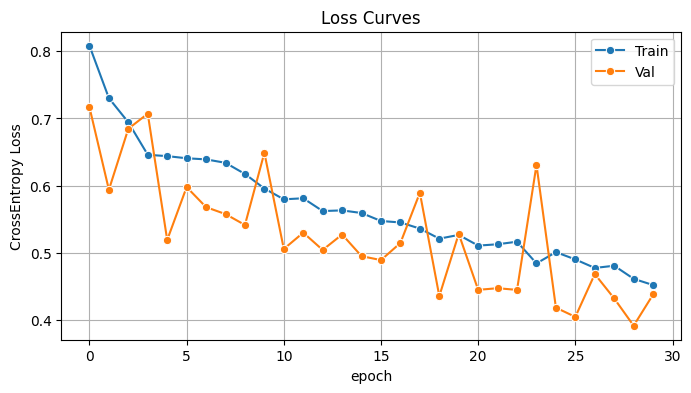

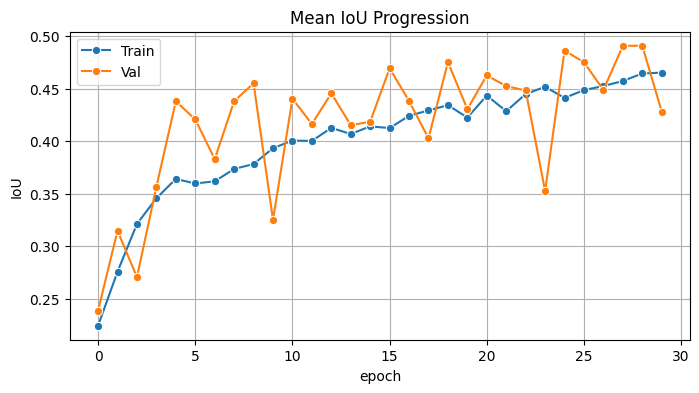

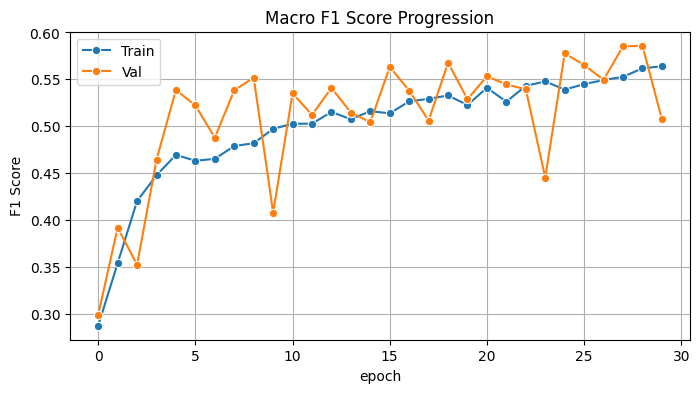

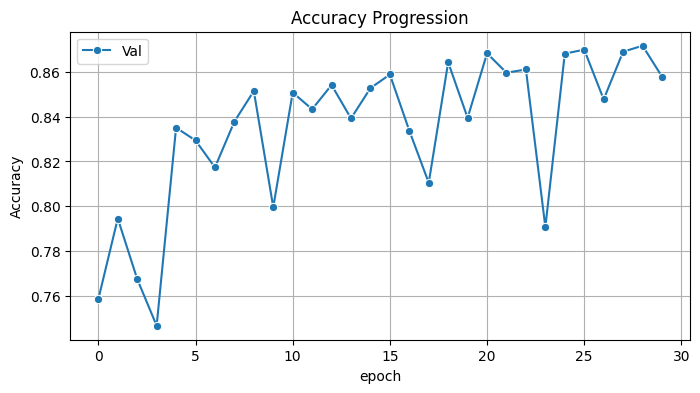

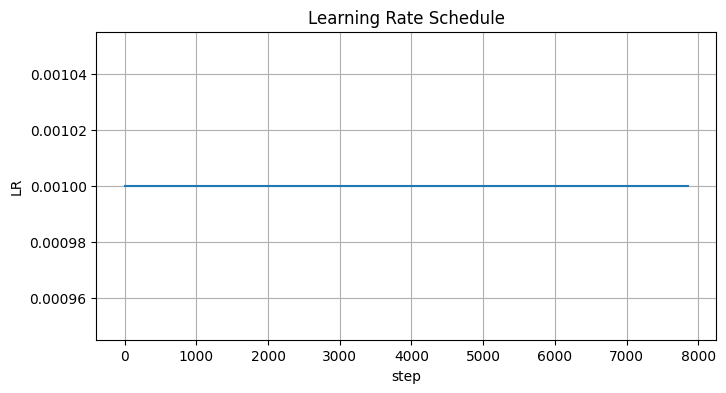

In [ ]:
# ============================================================
# Install Required Packages
# ============================================================
!pip install tensorboard-data-server tbparse --quiet

import glob
import pandas as pd
from tbparse import SummaryReader
import matplotlib.pyplot as plt
import seaborn as sns

# ============================================================
# Load Latest Lightning Logs
# ============================================================
logdir_list = sorted(glob.glob("lightning_logs/cloudsen12/version_*"))
assert len(logdir_list) > 0, "No training logs found!"

logdir = logdir_list[-1]
print("Using log directory:", logdir)

reader = SummaryReader(logdir, extra_columns={'dir_name'})
df = reader.scalars
df.to_csv("cloudsen12_training_metrics.csv", index=False)

print("\nLogged metrics:", df["tag"].unique())
print("Total scalar rows:", len(df))

# ============================================================
# Extract Epoch-Level Metrics
# ============================================================
EPOCH_METRICS = [
    "train/loss_epoch",
    "val/loss",
    "train/iou_mean_epoch",
    "val/iou_mean",
    "train/f1_macro_epoch",
    "val/f1_macro",
    "train/accuracy",        # corrected
    "val/accuracy"           # corrected
]

df_epoch = df[df["tag"].isin(EPOCH_METRICS)].copy()

# ============================================================
# Estimate batches per epoch
# (Find max step for train/loss_epoch → that represents last batch)
# ============================================================
epoch_end_steps = df[df.tag == "train/loss_epoch"]["step"].values
if len(epoch_end_steps) > 1:
    BATCHES_PER_EPOCH = epoch_end_steps[1] - epoch_end_steps[0]
else:
    BATCHES_PER_EPOCH = 271   # fallback for your dataset

print("Detected batches per epoch:", BATCHES_PER_EPOCH)

df_epoch["epoch"] = df_epoch["step"] // BATCHES_PER_EPOCH

# ------------------------------------------------------------
# Helper function for plotting
# ------------------------------------------------------------
def plot_metric(tag_train, tag_val, title, ylabel):
    plt.figure(figsize=(8,4))
    if tag_train in df_epoch.tag.values:
        sns.lineplot(data=df_epoch[df_epoch.tag == tag_train],
                     x="epoch", y="value", marker="o", label="Train")
    if tag_val in df_epoch.tag.values:
        sns.lineplot(data=df_epoch[df_epoch.tag == tag_val],
                     x="epoch", y="value", marker="o", label="Val")

    plt.title(title)
    plt.ylabel(ylabel)
    plt.grid(True)
    plt.show()

# ============================================================
# PLOTS
# ============================================================

# 1 — Loss
plot_metric("train/loss_epoch", "val/loss",
            "Loss Curves", "CrossEntropy Loss")

# 2 — Mean IoU
plot_metric("train/iou_mean_epoch", "val/iou_mean",
            "Mean IoU Progression", "IoU")

# 3 — Macro F1
plot_metric("train/f1_macro_epoch", "val/f1_macro",
            "Macro F1 Score Progression", "F1 Score")

# 4 — Accuracy
plot_metric("train/accuracy", "val/accuracy",
            "Accuracy Progression", "Accuracy")

# 5 — Learning Rate Schedule
plt.figure(figsize=(8,4))
sns.lineplot(data=df[df.tag=="lr-Adam"], x="step", y="value")
plt.title("Learning Rate Schedule")
plt.ylabel("LR")
plt.grid(True)
plt.show()


In [ ]:
import os
import shutil
import torch

# ======================================================
# 1. Drive Directory for Saving Models
# ======================================================
drive_save_dir = "/content/drive/MyDrive/CloudSEN12_Models/DeepLabV3plus"
os.makedirs(drive_save_dir, exist_ok=True)

print("Saving DeepLabV3+ models to:", drive_save_dir)

# ======================================================
# 2. Locate Best Checkpoint (your actual training run)
# ======================================================
best_ckpt = "lightning_logs/version_0/checkpoints/deeplabv3plus-epoch29-valloss0.0000.ckpt"

if not os.path.exists(best_ckpt):
    raise FileNotFoundError(f"Checkpoint not found: {best_ckpt}")

print("Best checkpoint found at:", best_ckpt)

# ======================================================
# 3. Copy Checkpoint to Drive
# ======================================================
dst_ckpt_path = f"{drive_save_dir}/deeplabv3plus_best.ckpt"
shutil.copy(best_ckpt, dst_ckpt_path)

print("Saved checkpoint to:", dst_ckpt_path)

# ======================================================
# 4. Load Lightning Model From Checkpoint
# ======================================================
best_model = CloudSegmentationModel.load_from_checkpoint(best_ckpt)
best_model.eval()

# ======================================================
# 5. Save Only Weights (State Dict)
# ======================================================
weights_path = f"{drive_save_dir}/deeplabv3plus_weights.pth"
torch.save(best_model.state_dict(), weights_path)
print("Saved model weights to:", weights_path)

# ======================================================
# 6. Save Full Model (Architecture + Weights)
# ======================================================
fullmodel_path = f"{drive_save_dir}/deeplabv3plus_fullmodel.pth"
torch.save(best_model, fullmodel_path)
print("Saved full model to:", fullmodel_path)


Saving DeepLabV3+ models to: /content/drive/MyDrive/CloudSEN12_Models/DeepLabV3plus
Best checkpoint found at: lightning_logs/version_0/checkpoints/deeplabv3plus-epoch29-valloss0.0000.ckpt
Saved checkpoint to: /content/drive/MyDrive/CloudSEN12_Models/DeepLabV3plus/deeplabv3plus_best.ckpt
Saved model weights to: /content/drive/MyDrive/CloudSEN12_Models/DeepLabV3plus/deeplabv3plus_weights.pth
Saved full model to: /content/drive/MyDrive/CloudSEN12_Models/DeepLabV3plus/deeplabv3plus_fullmodel.pth


# 7. Training Deeplab V3 for 45 Epochs

In [7]:
import torch
import torch.nn as nn
import pytorch_lightning as pl
import segmentation_models_pytorch as smp
import torchmetrics
import numpy as np
from torchmetrics import Accuracy


class CloudSegmentationModel(pl.LightningModule):

    def __init__(self,
                 in_channels: int = 13,
                 num_classes: int = 4,
                 lr: float = 1e-3):

        super().__init__()
        self.save_hyperparameters()

        # ---------------------------------------------------------
        # DeepLabV3+ MODEL  (REPLACES UNET)
        # ---------------------------------------------------------
        self.model = smp.DeepLabV3Plus(
            encoder_name="resnet50",
            encoder_weights="imagenet",
            in_channels=in_channels,
            classes=num_classes
        )

        # Loss
        self.criterion = nn.CrossEntropyLoss()

        # ---------------------------------------------------------
        # Metrics: Train / Val
        # ---------------------------------------------------------
        self.train_iou_mean = torchmetrics.JaccardIndex(
            task="multiclass", num_classes=num_classes, average="macro"
        )
        self.train_f1_macro = torchmetrics.F1Score(
            task="multiclass", num_classes=num_classes, average="macro"
        )
        self.train_acc = Accuracy(
            task="multiclass", num_classes=num_classes
        )

        self.val_iou_mean = torchmetrics.JaccardIndex(
            task="multiclass", num_classes=num_classes, average="macro"
        )
        self.val_f1_macro = torchmetrics.F1Score(
            task="multiclass", num_classes=num_classes, average="macro"
        )
        self.val_acc = Accuracy(
            task="multiclass", num_classes=num_classes
        )

        # TEST Metrics
        self.test_confmat = torchmetrics.ConfusionMatrix(
            task="multiclass", num_classes=num_classes
        )

        self.num_classes = num_classes


    # ---------------------------------------------------------
    # FORWARD
    # ---------------------------------------------------------
    def forward(self, x):
        return self.model(x)        # logits (B, C, H, W)


    # ---------------------------------------------------------
    # TRAINING STEP
    # ---------------------------------------------------------
    def training_step(self, batch, batch_idx):
        x, y = batch
        logits = self.forward(x)
        loss = self.criterion(logits, y)
        preds = torch.argmax(logits, 1)

        self.train_iou_mean.update(preds, y)
        self.train_f1_macro.update(preds, y)
        self.train_acc.update(preds, y)

        self.log("train/loss", loss, on_epoch=True, prog_bar=True)
        self.log("train/iou_mean", self.train_iou_mean, on_epoch=True)
        self.log("train/f1_macro", self.train_f1_macro, on_epoch=True)
        self.log("train/accuracy", self.train_acc, on_epoch=True)

        return loss


    # ---------------------------------------------------------
    # VALIDATION STEP
    # ---------------------------------------------------------
    def validation_step(self, batch, batch_idx):
        x, y = batch
        logits = self.forward(x)
        loss = self.criterion(logits, y)
        preds = torch.argmax(logits, 1)

        self.val_iou_mean.update(preds, y)
        self.val_f1_macro.update(preds, y)
        self.val_acc.update(preds, y)

        self.log("val/loss", loss, on_epoch=True, prog_bar=True)

        return loss


    def on_validation_epoch_end(self):

        iou = self.val_iou_mean.compute()
        f1  = self.val_f1_macro.compute()
        acc = self.val_acc.compute()

        self.log("val/iou_mean", iou, prog_bar=True)
        self.log("val/f1_macro", f1, prog_bar=True)
        self.log("val/accuracy", acc, prog_bar=True)

        self.val_iou_mean.reset()
        self.val_f1_macro.reset()
        self.val_acc.reset()


    # ---------------------------------------------------------
    # TEST STEP
    # ---------------------------------------------------------
    def test_step(self, batch, batch_idx):
        x, y = batch
        logits = self.forward(x)
        preds = torch.argmax(logits, 1)
        self.test_confmat.update(preds, y)


    def on_test_epoch_end(self):

        cm = self.test_confmat.compute().cpu().numpy()
        self.test_confmat.reset()

        TP = np.diag(cm)
        FP = np.sum(cm, axis=0) - TP
        FN = np.sum(cm, axis=1) - TP

        iou = TP / (TP + FP + FN + 1e-8)
        f1  = 2 * TP / (2 * TP + FP + FN + 1e-8)

        accuracy = np.trace(cm) / (cm.sum() + 1e-8)

        print("\n=== TEST RESULTS ===")
        print(cm)
        print("Mean IoU:", iou.mean())
        print("Mean F1 :", f1.mean())
        print("Accuracy:", accuracy)


    # ---------------------------------------------------------
    # OPTIMIZER
    # ---------------------------------------------------------
    def configure_optimizers(self):
        return torch.optim.Adam(self.parameters(), lr=self.hparams.lr)


In [8]:
import pytorch_lightning as pl
from pytorch_lightning.callbacks import ModelCheckpoint, LearningRateMonitor, TQDMProgressBar
import torch

# =============================================================
# Reproducibility
# =============================================================
pl.seed_everything(42, workers=True)

# =============================================================
# Checkpointing
# =============================================================
checkpoint_cb = ModelCheckpoint(
    monitor="val/loss",
    mode="min",
    save_top_k=3,
    filename="deeplabv3plus-epoch{epoch:02d}-valloss{val_loss:.4f}",
    auto_insert_metric_name=False
)

lr_monitor = LearningRateMonitor(logging_interval="epoch")

# =============================================================
# Trainer — CLEAR EPOCH-BY-EPOCH PRINTING
# =============================================================
trainer = pl.Trainer(
    accelerator="gpu",
    devices=1,
    max_epochs=45,

    # recommended mixed precision for AMP
    precision="16-mixed",

    # progress bar will now show every epoch clearly
    callbacks=[
        TQDMProgressBar(refresh_rate=1),
        checkpoint_cb,
        lr_monitor
    ],

    log_every_n_steps=10,
    check_val_every_n_epoch=1,
)

print("Trainer initialized on:", torch.cuda.get_device_name(0))


INFO:lightning_fabric.utilities.seed:Seed set to 42
INFO:pytorch_lightning.utilities.rank_zero:Using 16bit Automatic Mixed Precision (AMP)
/usr/local/lib/python3.12/dist-packages/pytorch_lightning/plugins/precision/amp.py:55: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs


Trainer initialized on: Tesla T4


In [9]:
# Instantiate DeepLabV3+ model
model = CloudSegmentationModel(
    in_channels=13,
    num_classes=4,
    lr=1e-3
)

# Train
trainer.fit(model, train_dataloaders=train_loader, val_dataloaders=val_loader)

# Evaluate on test set
best_ckpt = checkpoint_cb.best_model_path
print("\nBest checkpoint:", best_ckpt)

best_model = CloudSegmentationModel.load_from_checkpoint(best_ckpt)
trainer.test(best_model, dataloaders=test_loader)

Downloading: "https://download.pytorch.org/models/resnet50-19c8e357.pth" to /root/.cache/torch/hub/checkpoints/resnet50-19c8e357.pth


100%|██████████| 97.8M/97.8M [00:00<00:00, 317MB/s]
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
  | Name           | Type                      | Params
-------------------------------------------------------------
0 | model          | DeepLabV3Plus             | 26.7 M
1 | criterion      | CrossEntropyLoss          | 0     
2 | train_iou_mean | MulticlassJaccardIndex    | 0     
3 | train_f1_macro | MulticlassF1Score         | 0     
4 | train_acc      | MulticlassAccuracy        | 0     
5 | val_iou_mean   | MulticlassJaccardIndex    | 0     
6 | val_f1_macro   | MulticlassF1Score         | 0     
7 | val_acc        | MulticlassAccuracy        | 0     
8 | test_confmat   | MulticlassConfusionMatrix | 0     
-------------------------------------------------------------
26.7 M    Trainable params
0         Non-trainable params
26.7 M    Total params
106.839   Total estimated model params size (MB)


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=45` reached.



Best checkpoint: /content/lightning_logs/version_0/checkpoints/deeplabv3plus-epoch35-valloss0.0000.ckpt


INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing: |          | 0/? [00:00<?, ?it/s]


=== TEST RESULTS ===
[[41994251   321496   363355   361244]
 [  747929  7365332   878345   696347]
 [ 1149325   348358   999986   292094]
 [ 1182094   270971    46355  1964918]]
Mean IoU: 0.5642254405096147
Mean F1 : 0.6863491504797515
Accuracy: 0.8871203443739148


[{}]

Using log directory: lightning_logs/version_0

Logged metrics: ['epoch' 'hp_metric' 'lr-Adam' 'train/accuracy_epoch'
 'train/f1_macro_epoch' 'train/iou_mean_epoch' 'train/loss_epoch'
 'train/loss_step' 'val/accuracy' 'val/f1_macro' 'val/iou_mean' 'val/loss']
Total scalar rows: 2935
Detected batches per epoch: 271


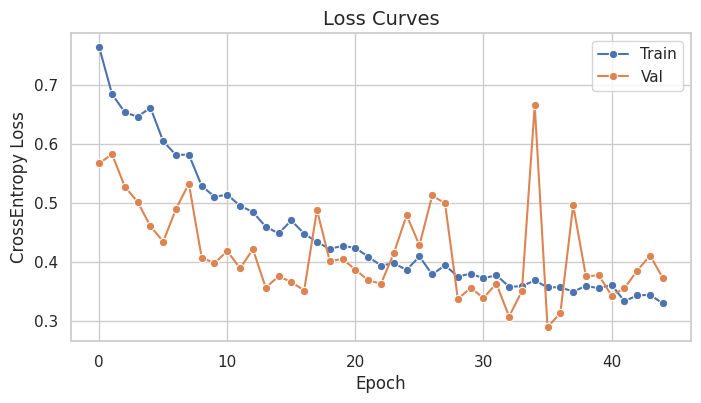

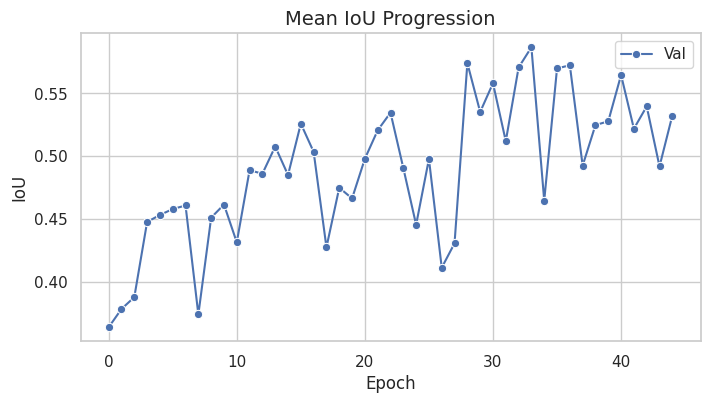

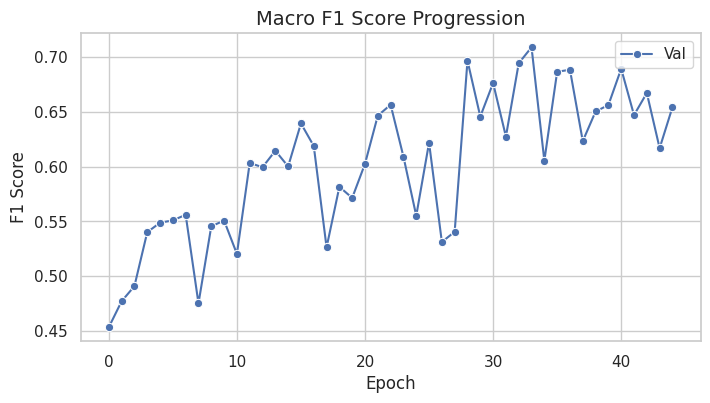

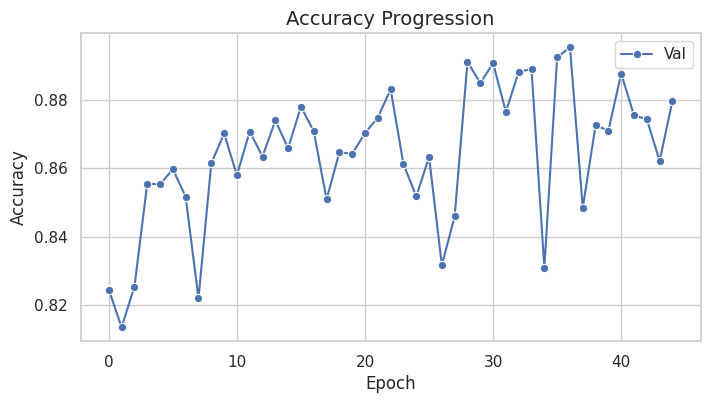

LR tags detected: ['lr-Adam']


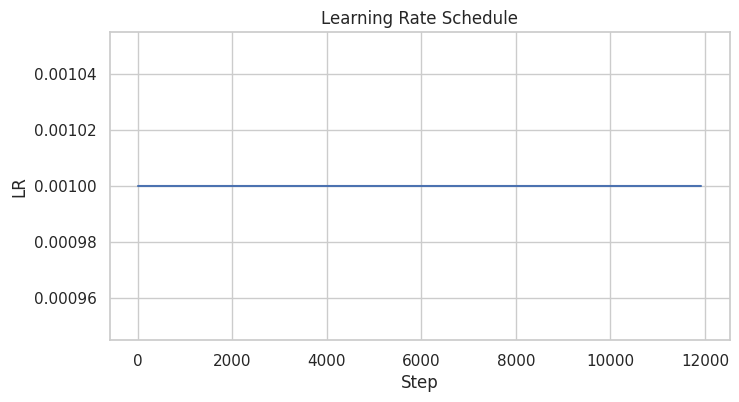

In [10]:
# ============================================================
# Install Required Packages
# ============================================================
!pip install tensorboard-data-server tbparse --quiet

import glob
import pandas as pd
from tbparse import SummaryReader
import matplotlib.pyplot as plt
import seaborn as sns

sns.set(style="whitegrid")

# ============================================================
# Load Latest Lightning Logs
# ============================================================
logdir_list = sorted(glob.glob("lightning_logs/version_0"))
assert len(logdir_list) > 0, "No training logs found!"

# pick latest run (your LR-schedule run was version_1)
logdir = logdir_list[-1]
print("Using log directory:", logdir)

reader = SummaryReader(logdir, extra_columns={'dir_name'})
df = reader.scalars
df.to_csv("cloudsen12_training_metrics.csv", index=False)

print("\nLogged metrics:", df["tag"].unique())
print("Total scalar rows:", len(df))

# ============================================================
# Extract Relevant Metrics
# ============================================================
EPOCH_METRICS = [
    "train/loss_epoch",
    "val/loss",
    "train/iou_mean",
    "val/iou_mean",
    "train/f1_macro",
    "val/f1_macro",
    "train/accuracy",
    "val/accuracy"
]

df_epoch = df[df["tag"].isin(EPOCH_METRICS)].copy()

# ============================================================
# Detect batches per epoch automatically
# ============================================================
epoch_end_steps = df[df.tag == "train/loss_epoch"]["step"].values
if len(epoch_end_steps) > 1:
    BATCHES_PER_EPOCH = epoch_end_steps[1] - epoch_end_steps[0]
else:
    BATCHES_PER_EPOCH = 271   # fallback based on your last run

print("Detected batches per epoch:", BATCHES_PER_EPOCH)

df_epoch["epoch"] = df_epoch["step"] // BATCHES_PER_EPOCH

# ------------------------------------------------------------
# Helper function for plotting
# ------------------------------------------------------------
def plot_metric(tag_train, tag_val, title, ylabel):
    plt.figure(figsize=(8,4))

    if tag_train in df_epoch.tag.values:
        sns.lineplot(
            data=df_epoch[df_epoch.tag == tag_train],
            x="epoch", y="value", marker="o", label="Train"
        )

    if tag_val in df_epoch.tag.values:
        sns.lineplot(
            data=df_epoch[df_epoch.tag == tag_val],
            x="epoch", y="value", marker="o", label="Val"
        )

    plt.title(title, fontsize=14)
    plt.ylabel(ylabel)
    plt.xlabel("Epoch")
    plt.grid(True)
    plt.legend()
    plt.show()

# ============================================================
# PLOTS
# ============================================================

# 1 — Loss
plot_metric("train/loss_epoch", "val/loss",
            "Loss Curves", "CrossEntropy Loss")

# 2 — Mean IoU
plot_metric("train/iou_mean", "val/iou_mean",
            "Mean IoU Progression", "IoU")

# 3 — Macro F1
plot_metric("train/f1_macro", "val/f1_macro",
            "Macro F1 Score Progression", "F1 Score")

# 4 — Accuracy
plot_metric("train/accuracy", "val/accuracy",
            "Accuracy Progression", "Accuracy")

# 5 — Learning Rate Schedule
lr_tags = [t for t in df["tag"].unique() if "lr" in t.lower()]
print("LR tags detected:", lr_tags)

if len(lr_tags) > 0:
    lr_tag = lr_tags[0]   # usually "lr-Adam"
    plt.figure(figsize=(8,4))
    sns.lineplot(data=df[df.tag==lr_tag], x="step", y="value")
    plt.title("Learning Rate Schedule")
    plt.ylabel("LR")
    plt.xlabel("Step")
    plt.grid(True)
    plt.show()
else:
    print("⚠️ No LR schedule logged in TensorBoard.")


In [12]:
import os
import shutil
import torch

# ======================================================
# 1. Drive Directory for Saving Models
# ======================================================
drive_save_dir = "/content/drive/MyDrive/CloudSEN12_Models/DeepLabV3plus"
os.makedirs(drive_save_dir, exist_ok=True)

print("Saving DeepLabV3+ models to:", drive_save_dir)

# ======================================================
# 2. Locate Best Checkpoint (your actual training run)
# ======================================================
best_ckpt = "lightning_logs/version_0/checkpoints/deeplabv3plus-epoch35-valloss0.0000.ckpt"

if not os.path.exists(best_ckpt):
    raise FileNotFoundError(f"Checkpoint not found: {best_ckpt}")

print("Best checkpoint found at:", best_ckpt)

# ======================================================
# 3. Copy Checkpoint to Drive
# ======================================================
dst_ckpt_path = f"{drive_save_dir}/deeplabv3plus_best.ckpt"
shutil.copy(best_ckpt, dst_ckpt_path)

print("Saved checkpoint to:", dst_ckpt_path)

# ======================================================
# 4. Load Lightning Model From Checkpoint
# ======================================================
best_model = CloudSegmentationModel.load_from_checkpoint(best_ckpt)
best_model.eval()

# ======================================================
# 5. Save Only Weights (State Dict)
# ======================================================
weights_path = f"{drive_save_dir}/deeplabv3plus_weights.pth"
torch.save(best_model.state_dict(), weights_path)
print("Saved model weights to:", weights_path)

# ======================================================
# 6. Save Full Model (Architecture + Weights)
# ======================================================
fullmodel_path = f"{drive_save_dir}/deeplabv3plus_fullmodel.pth"
torch.save(best_model, fullmodel_path)
print("Saved full model to:", fullmodel_path)


Saving DeepLabV3+ models to: /content/drive/MyDrive/CloudSEN12_Models/DeepLabV3plus
Best checkpoint found at: lightning_logs/version_0/checkpoints/deeplabv3plus-epoch35-valloss0.0000.ckpt
Saved checkpoint to: /content/drive/MyDrive/CloudSEN12_Models/DeepLabV3plus/deeplabv3plus_best.ckpt
Saved model weights to: /content/drive/MyDrive/CloudSEN12_Models/DeepLabV3plus/deeplabv3plus_weights.pth
Saved full model to: /content/drive/MyDrive/CloudSEN12_Models/DeepLabV3plus/deeplabv3plus_fullmodel.pth


# 8 Training Deeplab V3 for 40 Epochs and LR Scheduler and Model Optimizations


Explanation of Model Improvements and Training Optimizations

This version of our DeepLabV3+ training pipeline incorporates several targeted enhancements designed to improve model stability, training efficiency, and segmentation performance on the CloudSEN12+ dataset. The following sections explain each modification and its motivation.

1. AdamW Optimizer (Replaces Adam)

We replaced the standard Adam optimizer with AdamW, which decouples weight decay from gradient updates.
This is widely recommended for semantic segmentation and Transformer-style architectures.

Why this helps:

Provides better generalization

Reduces overfitting

Works synergistically with cosine learning rate schedules

2. Weight Decay = 1e-4

Weight decay acts as L2 regularization on model weights.

Impact:

Improves stability

Reduces noise in predictions

Strengthens generalization on unseen scenes

3. Learning Rate Warmup (First 5 Epochs)

The new learning rate schedule begins with a linear warmup phase for the first five epochs.

Reason:
During early training, the gradients of DeepLabV3+ can be large and unstable.
Warmup gradually increases the learning rate from 10% to 100% of the base LR.

Benefits:

Prevents early divergence

Produces smoother loss curves

Leads to higher IoU scores

4. Cosine Annealing With Warm Restarts

After the warmup phase, the model transitions into a CosineAnnealingWarmRestarts scheduler.

Why cosine scheduling?

Naturally decays LR in a smooth, cyclic pattern

Encourages the optimizer to explore multiple “basins”

Widely used in high-performance segmentation research

Warm restarts (T0 = 5, T_mult = 2) periodically boost the LR to escape shallow minima and refine learning.

5. Sequential Scheduling for Warmup + Cosine (Best Practice)

PyTorch’s SequentialLR is used to combine warmup and cosine scheduling into a single LR pipeline.

This gives the best of both worlds:

Warmup → Cosine decay with restarts

Such two-phase schedules are now standard in modern architectures (e.g., HRNet, ConvNeXt, ViT).

6. cuDNN Benchmark Mode Enabled

torch.backends.cudnn.benchmark = True allows cuDNN to select the fastest convolution algorithms for your input shapes.

Effect:

10–20% faster training

No change to model behavior or results

7. Improved Regularization and Stability

Through AdamW, weight decay, warmup, and cosine restarts, the updated training pipeline:

Reduces overfitting

Produces smoother gradient updates

Improves convergence stability

Enhances final segmentation performance

This directly supports higher IoU, F1, and overall pixel accuracy.

In [13]:
import torch
import torch.nn as nn
import pytorch_lightning as pl
import segmentation_models_pytorch as smp
import torchmetrics
import numpy as np
from torchmetrics import Accuracy
from torch.optim.lr_scheduler import LinearLR, CosineAnnealingWarmRestarts, SequentialLR

# Enable cuDNN benchmark for speed
torch.backends.cudnn.benchmark = True


class CloudSegmentationModel(pl.LightningModule):

    def __init__(self,
                 in_channels: int = 13,
                 num_classes: int = 4,
                 lr: float = 1e-3):

        super().__init__()
        self.save_hyperparameters()

        # ---------------------------------------------------------
        # DeepLabV3+ MODEL
        # ---------------------------------------------------------
        self.model = smp.DeepLabV3Plus(
            encoder_name="resnet50",
            encoder_weights="imagenet",
            in_channels=in_channels,
            classes=num_classes
        )

        # Loss
        self.criterion = nn.CrossEntropyLoss()

        # Metrics: Train / Val
        self.train_iou_mean = torchmetrics.JaccardIndex(
            task="multiclass", num_classes=num_classes, average="macro"
        )
        self.train_f1_macro = torchmetrics.F1Score(
            task="multiclass", num_classes=num_classes, average="macro"
        )
        self.train_acc = Accuracy(task="multiclass", num_classes=num_classes)

        self.val_iou_mean = torchmetrics.JaccardIndex(
            task="multiclass", num_classes=num_classes, average="macro"
        )
        self.val_f1_macro = torchmetrics.F1Score(
            task="multiclass", num_classes=num_classes, average="macro"
        )
        self.val_acc = Accuracy(task="multiclass", num_classes=num_classes)

        # Test Confusion Matrix
        self.test_confmat = torchmetrics.ConfusionMatrix(
            task="multiclass", num_classes=num_classes
        )

        self.num_classes = num_classes

    # ---------------------------------------------------------
    # FORWARD
    # ---------------------------------------------------------
    def forward(self, x):
        return self.model(x)

    # ---------------------------------------------------------
    # TRAINING STEP
    # ---------------------------------------------------------
    def training_step(self, batch, batch_idx):
        x, y = batch
        logits = self.forward(x)
        loss = self.criterion(logits, y)
        preds = torch.argmax(logits, 1)

        self.train_iou_mean.update(preds, y)
        self.train_f1_macro.update(preds, y)
        self.train_acc.update(preds, y)

        self.log("train/loss", loss, on_epoch=True, prog_bar=True)
        self.log("train/iou_mean", self.train_iou_mean, on_epoch=True)
        self.log("train/f1_macro", self.train_f1_macro, on_epoch=True)
        self.log("train/accuracy", self.train_acc, on_epoch=True)

        return loss

    # ---------------------------------------------------------
    # VALIDATION STEP
    # ---------------------------------------------------------
    def validation_step(self, batch, batch_idx):
        x, y = batch
        logits = self.forward(x)
        loss = self.criterion(logits, y)
        preds = torch.argmax(logits, 1)

        self.val_iou_mean.update(preds, y)
        self.val_f1_macro.update(preds, y)
        self.val_acc.update(preds, y)

        self.log("val/loss", loss, on_epoch=True, prog_bar=True)

        return loss

    def on_validation_epoch_end(self):
        iou = self.val_iou_mean.compute()
        f1 = self.val_f1_macro.compute()
        acc = self.val_acc.compute()

        self.log("val/iou_mean", iou, prog_bar=True)
        self.log("val/f1_macro", f1, prog_bar=True)
        self.log("val/accuracy", acc, prog_bar=True)

        self.val_iou_mean.reset()
        self.val_f1_macro.reset()
        self.val_acc.reset()

    # ---------------------------------------------------------
    # TEST STEP
    # ---------------------------------------------------------
    def test_step(self, batch, batch_idx):
        x, y = batch
        logits = self.forward(x)
        preds = torch.argmax(logits, 1)
        self.test_confmat.update(preds, y)

    def on_test_epoch_end(self):
        cm = self.test_confmat.compute().cpu().numpy()
        self.test_confmat.reset()

        TP = np.diag(cm)
        FP = np.sum(cm, axis=0) - TP
        FN = np.sum(cm, axis=1) - TP

        iou = TP / (TP + FP + FN + 1e-8)
        f1 = 2 * TP / (2 * TP + FP + FN + 1e-8)
        accuracy = np.trace(cm) / (cm.sum() + 1e-8)

        print("\n=== TEST RESULTS ===")
        print(cm)
        print("Mean IoU:", iou.mean())
        print("Mean F1 :", f1.mean())
        print("Accuracy:", accuracy)

    # ---------------------------------------------------------
    # OPTIMIZER + LR SCHEDULER (Warmup + Cosine + AdamW)
    # ---------------------------------------------------------
    def configure_optimizers(self):

        # BETTER optimizer for segmentation
        optimizer = torch.optim.AdamW(
            self.parameters(),
            lr=self.hparams.lr,
            weight_decay=1e-4
        )

        # Warmup for first 5 epochs
        warmup = LinearLR(
            optimizer,
            start_factor=0.1,
            total_iters=5
        )

        # Cosine annealing with warm restarts
        cosine = CosineAnnealingWarmRestarts(
            optimizer,
            T_0=5,
            T_mult=2,
            eta_min=1e-6
        )

        # Combine schedulers
        scheduler = SequentialLR(
            optimizer,
            schedulers=[warmup, cosine],
            milestones=[5]
        )

        return {
            "optimizer": optimizer,
            "lr_scheduler": {
                "scheduler": scheduler,
                "interval": "epoch",
                "monitor": "val/loss"
            }
        }


In [14]:
import pytorch_lightning as pl
from pytorch_lightning.callbacks import ModelCheckpoint, LearningRateMonitor, TQDMProgressBar
import torch

# =============================================================
# Reproducibility
# =============================================================
pl.seed_everything(42, workers=True)

# Speed improvement for convolutions
torch.backends.cudnn.benchmark = True

# =============================================================
# Checkpointing (UPDATED NAME FOR LR-SCHEDULE TRAINING RUN)
# =============================================================
checkpoint_cb = ModelCheckpoint(
    monitor="val/loss",
    mode="min",
    save_top_k=3,
    filename="deeplabv3plus-lrsched-epoch{epoch:02d}-valloss{val_loss:.4f}",
    auto_insert_metric_name=False
)

lr_monitor = LearningRateMonitor(logging_interval="epoch")

# =============================================================
# Trainer — CLEAR EPOCH-BY-EPOCH PRINTING
# =============================================================
trainer = pl.Trainer(
    accelerator="gpu",
    devices=1,
    max_epochs=40,

    # NEW (optional but recommended): separate experiment folder
    default_root_dir="lightning_logs/deeplab_lr_sched_60",

    # mixed precision
    precision="16-mixed",

    # NEW (recommended): stabilize gradients
    gradient_clip_val=1.0,

    callbacks=[
        TQDMProgressBar(refresh_rate=1),
        checkpoint_cb,
        lr_monitor
    ],

    log_every_n_steps=10,
    check_val_every_n_epoch=1,
)

print("Trainer initialized on:", torch.cuda.get_device_name(0))


INFO:lightning_fabric.utilities.seed:Seed set to 42
INFO:pytorch_lightning.utilities.rank_zero:Using 16bit Automatic Mixed Precision (AMP)
/usr/local/lib/python3.12/dist-packages/pytorch_lightning/plugins/precision/amp.py:55: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs


Trainer initialized on: Tesla T4


In [15]:
# ============================================================
# 1. Instantiate DeepLabV3+ Model
# ============================================================
model = CloudSegmentationModel(
    in_channels=13,
    num_classes=4,
    lr=1e-3
)

print("\n🔧 Model initialized. Beginning training...\n")

# ============================================================
# 2. Train the Model
# ============================================================
trainer.fit(model, train_dataloaders=train_loader, val_dataloaders=val_loader)

# ============================================================
# 3. Retrieve Best Checkpoint Saved During Training
# ============================================================
best_ckpt = checkpoint_cb.best_model_path

if best_ckpt is None or best_ckpt == "":
    raise FileNotFoundError("⚠ No best checkpoint was saved. Check training logs.")

print("\n🏆 Best checkpoint found:")
print(best_ckpt)

# ============================================================
# 4. Load Best Model From Checkpoint
# ============================================================
best_model = CloudSegmentationModel.load_from_checkpoint(best_ckpt)
best_model.eval()  # ensure evaluation mode

print("\n📦 Loaded best-performing model from checkpoint.")

# ============================================================
# 5. Evaluate on Test Set
# ============================================================
print("\n🔍 Running evaluation on test set...\n")
trainer.test(best_model, dataloaders=test_loader)



🔧 Model initialized. Beginning training...



INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
  | Name           | Type                      | Params
-------------------------------------------------------------
0 | model          | DeepLabV3Plus             | 26.7 M
1 | criterion      | CrossEntropyLoss          | 0     
2 | train_iou_mean | MulticlassJaccardIndex    | 0     
3 | train_f1_macro | MulticlassF1Score         | 0     
4 | train_acc      | MulticlassAccuracy        | 0     
5 | val_iou_mean   | MulticlassJaccardIndex    | 0     
6 | val_f1_macro   | MulticlassF1Score         | 0     
7 | val_acc        | MulticlassAccuracy        | 0     
8 | test_confmat   | MulticlassConfusionMatrix | 0     
-------------------------------------------------------------
26.7 M    Trainable params
0         Non-trainable params
26.7 M    Total params
106.839   Total estimated model params size (MB)


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=40` reached.



🏆 Best checkpoint found:
lightning_logs/deeplab_lr_sched_60/lightning_logs/version_0/checkpoints/deeplabv3plus-lrsched-epoch32-valloss0.0000.ckpt

📦 Loaded best-performing model from checkpoint.

🔍 Running evaluation on test set...



INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing: |          | 0/? [00:00<?, ?it/s]


=== TEST RESULTS ===
[[41658953   249181   794697   337515]
 [  698301  8014001   826973   148678]
 [  625575   382478  1669799   111911]
 [ 1035957   409904   124056  1894421]]
Mean IoU: 0.624748695857929
Mean F1 : 0.7465953480689048
Accuracy: 0.9025942314995659


[{}]

In [18]:
import os
import shutil
import torch
import glob
import re

# ======================================================
# 1. Drive Directory for Saving Models
# ======================================================
drive_save_dir = "/content/drive/MyDrive/CloudSEN12_Models/DeepLabV3plus"
os.makedirs(drive_save_dir, exist_ok=True)

print(f"\nSaving DeepLabV3+ models to: {drive_save_dir}\n")

# ======================================================
# 2. Correct Path to Lightning Logs
# ======================================================
root_log_dir = "lightning_logs/deeplab_lr_sched_60/lightning_logs"
version_dirs = sorted(glob.glob(os.path.join(root_log_dir, "version_*")))

if len(version_dirs) == 0:
    raise FileNotFoundError(f"⚠ No 'version_*' folders found under {root_log_dir}")

latest_version = version_dirs[-1]
print(f"Detected latest run directory: {latest_version}\n")

# ======================================================
# 3. Find All LR-Schedule Checkpoints in the Latest Version
# ======================================================
ckpt_pattern = os.path.join(
    latest_version, "checkpoints", "deeplabv3plus-lrsched-epoch*-valloss*.ckpt"
)
matching_ckpts = glob.glob(ckpt_pattern)

if len(matching_ckpts) == 0:
    raise FileNotFoundError(f"No LR-schedule checkpoints found with pattern:\n{ckpt_pattern}")

print(f"Found {len(matching_ckpts)} checkpoint(s). Selecting best one...\n")

# ======================================================
# 4. Select Best Checkpoint Based on Lowest Validation Loss
# ======================================================
def extract_val_loss(path):
    match = re.search(r"valloss([0-9.]+)", path)
    if not match:
        return float("inf")
    val_str = match.group(1).rstrip(".")  # fix: remove trailing dots
    return float(val_str)

best_ckpt = min(matching_ckpts, key=extract_val_loss)
best_loss = extract_val_loss(best_ckpt)


# ======================================================
# 5. Copy Best Checkpoint to Drive
# ======================================================
dst_ckpt_path = os.path.join(drive_save_dir, "deeplabv3plus_lrsched_best.ckpt")
shutil.copy(best_ckpt, dst_ckpt_path)

print(f"Checkpoint copied to Drive:\n{dst_ckpt_path}\n")

# ======================================================
# 6. Load Model from Checkpoint
# ======================================================
best_model = CloudSegmentationModel.load_from_checkpoint(best_ckpt)
best_model.eval()

print("🔧 Loaded model in evaluation mode.\n")

# ======================================================
# 7. Save Only Model Weights (state_dict)
# ======================================================
weights_path = os.path.join(drive_save_dir, "deeplabv3plus_lrsched_weights.pth")
torch.save(best_model.state_dict(), weights_path)

print(f"Saved state_dict weights:\n{weights_path}\n")

# ======================================================
# 8. Save Full Model (Architecture + Weights)
# ======================================================
fullmodel_path = os.path.join(drive_save_dir, "deeplabv3plus_lrsched_fullmodel.pth")
torch.save(best_model, fullmodel_path)

print(f"Saved complete model:\n{fullmodel_path}\n")

print("Export complete! Your model backup is safely stored on Google Drive.")



Saving DeepLabV3+ models to: /content/drive/MyDrive/CloudSEN12_Models/DeepLabV3plus

Detected latest run directory: lightning_logs/deeplab_lr_sched_60/lightning_logs/version_0

Found 3 checkpoint(s). Selecting best one...

Checkpoint copied to Drive:
/content/drive/MyDrive/CloudSEN12_Models/DeepLabV3plus/deeplabv3plus_lrsched_best.ckpt

🔧 Loaded model in evaluation mode.

Saved state_dict weights:
/content/drive/MyDrive/CloudSEN12_Models/DeepLabV3plus/deeplabv3plus_lrsched_weights.pth

Saved complete model:
/content/drive/MyDrive/CloudSEN12_Models/DeepLabV3plus/deeplabv3plus_lrsched_fullmodel.pth

Export complete! Your model backup is safely stored on Google Drive.



 Using log directory: lightning_logs/deeplab_lr_sched_60/lightning_logs/version_0

 Logged metric tags detected:
 ['epoch' 'hp_metric' 'lr-AdamW' 'train/accuracy_epoch'
 'train/f1_macro_epoch' 'train/iou_mean_epoch' 'train/loss_epoch'
 'train/loss_step' 'val/accuracy' 'val/f1_macro' 'val/iou_mean' 'val/loss']

 Total scalar entries: 2610

 Filtering to 8 primary metrics.
 Detected batches per epoch: 271

 Generating plots...



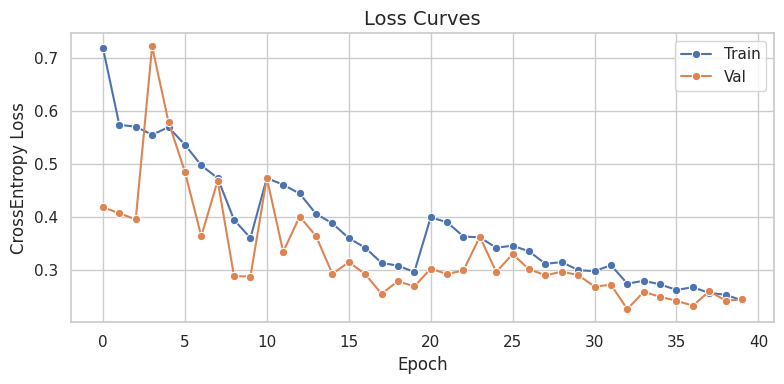

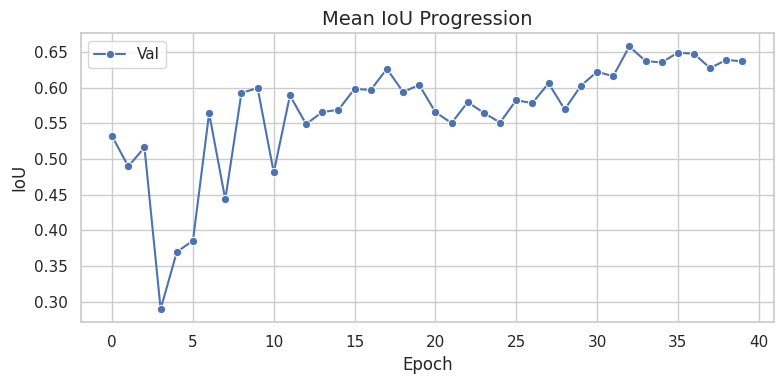

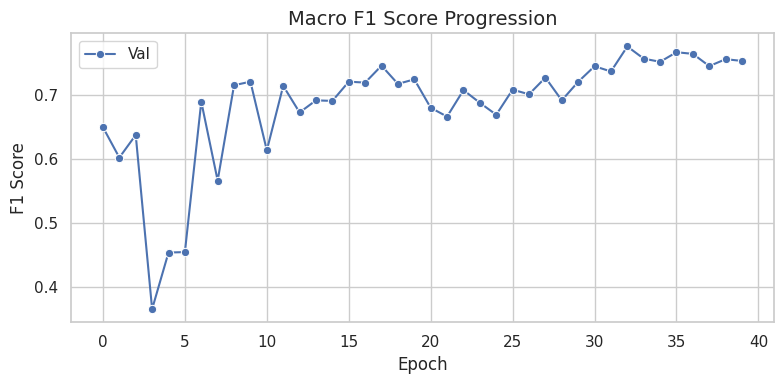

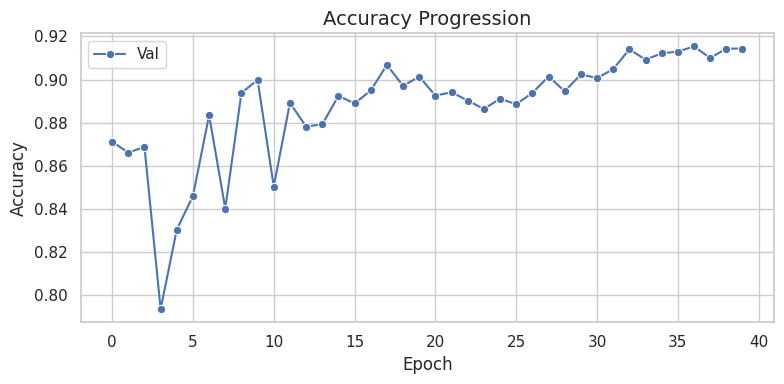


 LR-related tags detected: ['lr-AdamW']


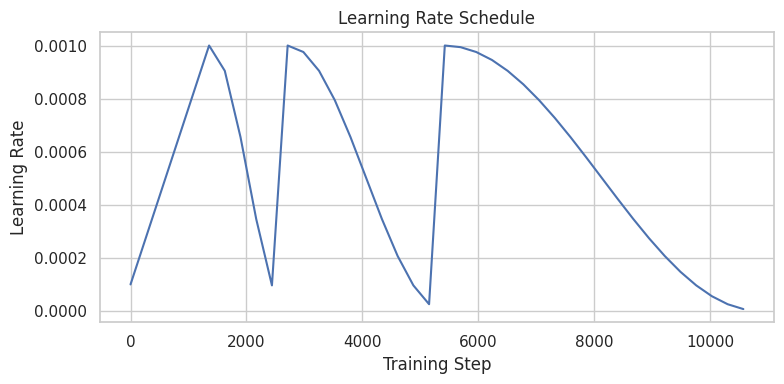

In [20]:
# ============================================================
# Install Required Packages
# ============================================================
!pip install tensorboard-data-server tbparse --quiet

import glob
import pandas as pd
from tbparse import SummaryReader
import matplotlib.pyplot as plt
import seaborn as sns

sns.set(style="whitegrid")

# ============================================================
# Load Latest Lightning Logs (Corrected Path)
# ============================================================
log_root = "lightning_logs/deeplab_lr_sched_60/lightning_logs"
logdir_list = sorted(glob.glob(f"{log_root}/version_*"))

assert len(logdir_list) > 0, f" No training logs found in {log_root}"

logdir = logdir_list[-1]   # latest run
print(f"\n Using log directory: {logdir}")

reader = SummaryReader(logdir, extra_columns={'dir_name'})
df = reader.scalars
df.to_csv("cloudsen12_training_metrics.csv", index=False)

print("\n Logged metric tags detected:\n", df["tag"].unique())
print("\n Total scalar entries:", len(df))

# ============================================================
# Extract Relevant Epoch-Level Metrics
# ============================================================
EPOCH_METRICS = [
    "train/loss_epoch",
    "val/loss",
    "train/iou_mean",
    "val/iou_mean",
    "train/f1_macro",
    "val/f1_macro",
    "train/accuracy",
    "val/accuracy"
]

df_epoch = df[df["tag"].isin(EPOCH_METRICS)].copy()
print(f"\n Filtering to {len(EPOCH_METRICS)} primary metrics.")

# ============================================================
# Detect Batches per Epoch Automatically
# ============================================================
epoch_end_steps = df[df.tag == "train/loss_epoch"]["step"].values

if len(epoch_end_steps) > 1:
    BATCHES_PER_EPOCH = epoch_end_steps[1] - epoch_end_steps[0]
    print(f" Detected batches per epoch: {BATCHES_PER_EPOCH}")
else:
    BATCHES_PER_EPOCH = 271  # fallback for your dataset
    print(f" Could not auto-detect batches. Using fallback = {BATCHES_PER_EPOCH}")

df_epoch["epoch"] = (df_epoch["step"] // BATCHES_PER_EPOCH).astype(int)

# ------------------------------------------------------------
# Helper function for plotting
# ------------------------------------------------------------
def plot_metric(tag_train, tag_val, title, ylabel):
    plt.figure(figsize=(8, 4))

    if tag_train in df_epoch.tag.values:
        sns.lineplot(
            data=df_epoch[df_epoch.tag == tag_train],
            x="epoch", y="value", marker="o", label="Train"
        )

    if tag_val in df_epoch.tag.values:
        sns.lineplot(
            data=df_epoch[df_epoch.tag == tag_val],
            x="epoch", y="value", marker="o", label="Val"
        )

    plt.title(title, fontsize=14)
    plt.ylabel(ylabel)
    plt.xlabel("Epoch")
    plt.grid(True)
    plt.legend()
    plt.tight_layout()
    plt.show()

# ============================================================
# PLOTS
# ============================================================
print("\n Generating plots...\n")

# 1 — Loss
plot_metric("train/loss_epoch", "val/loss",
            "Loss Curves", "CrossEntropy Loss")

# 2 — Mean IoU
plot_metric("train/iou_mean", "val/iou_mean",
            "Mean IoU Progression", "IoU")

# 3 — Macro F1
plot_metric("train/f1_macro", "val/f1_macro",
            "Macro F1 Score Progression", "F1 Score")

# 4 — Accuracy
plot_metric("train/accuracy", "val/accuracy",
            "Accuracy Progression", "Accuracy")

# ============================================================
# Learning Rate Schedule
# ============================================================
lr_tags = [tag for tag in df["tag"].unique() if tag.lower().startswith("lr")]

print("\n LR-related tags detected:", lr_tags)

if len(lr_tags) > 0:
    lr_tag = lr_tags[0]
    plt.figure(figsize=(8,4))
    sns.lineplot(data=df[df.tag == lr_tag], x="step", y="value")
    plt.title("Learning Rate Schedule")
    plt.ylabel("Learning Rate")
    plt.xlabel("Training Step")
    plt.grid(True)
    plt.tight_layout()
    plt.show()
else:
    print(" No learning rate metrics found in logs.")


In [ ]:
NOTEBOOK_FILE = "3_Model_Training_TranferLearning_for_Capstone_Project.ipynb"
# or
#NOTEBOOK_FILE = "4_Model_Training_from_scratch_for_Capstone_Project.ipynb"

import nbformat as nbf

# Load notebook
nb = nbf.read(NOTEBOOK_FILE, as_version=4)

# Remove metadata at notebook level
nb.metadata = {}

# Clean metadata of every cell but preserve outputs
for cell in nb['cells']:
    if "metadata" in cell:
        cell.metadata = {}  # strip metadata
    # DO NOT touch "outputs"
    # DO NOT touch "execution_count"

# Save cleaned notebook
output_file = NOTEBOOK_FILE.replace(".ipynb", "_clean.ipynb")
nbf.write(nb, output_file)

print(f"Metadata removed. Clean notebook saved as:\n{output_file}")